In [1]:
import braidz_analysis as bz
from pathlib import Path
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, find_peaks

2026-01-07 14:28:21,605 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [17]:
folder = "/home/buchsbaum/mnt/experiments"
files = ["20260106_142948.braidz", "20251219_143603.braidz"]

In [ ]:
dfs = []
optos = []
for file in files:
    filepath = os.path.join(folder, file)

    with ZipFile(filepath, 'r') as zip_ref:
        df = pd.read_csv(zip_ref.open("kalman_estimates.csv.gz"), compression='gzip', comment='#')
        opto = pd.read_csv(zip_ref.open("opto.csv"))

    df["file"] = file
    opto["file"] = file

    dfs.append(df)
    optos.append(opto)

df = pd.concat(dfs, ignore_index=True)
opto = pd.concat(optos, ignore_index=True)

In [ ]:
print(f"Number of opto trials: {len(opto)}")

Number of opto trials: 58


In [13]:
results = {"angular_velocity": [], "peak_angular_velocity": [], "intensity": [], "duration": []}

idx_before = 50
idx_after = 50

for idx, row in opto.iterrows():
    obj_id = int(row['obj_id'])
    frame = int(row['frame'])
    intensity = float(row['intensity'])
    duration = float(row['duration'])

    opto_idx = np.where((df['obj_id'] == obj_id) & (df['frame'] == frame))[0][0]
    
    if opto_idx-idx_before < 0 or opto_idx+idx_after>=len(df):
        continue

    xvel = savgol_filter(df["xvel"], window_length=11, polyorder=3)
    yvel = savgol_filter(df["yvel"], window_length=11, polyorder=3)

    theta = np.arctan2(yvel, xvel)
    theta_unwrap = np.unwrap(theta)
    angular_velocity = np.gradient(theta_unwrap, 0.01)

    angular_velocity_smooth = savgol_filter(angular_velocity, window_length=11, polyorder=3)

    # extract window around opto
    ang_vel_window = angular_velocity_smooth[opto_idx-idx_before:opto_idx+idx_after]

    # Find peak within response window
    peak_ang_vel = np.max(np.abs(np.rad2deg(ang_vel_window[50:80])))
    
    # Append results
    results["angular_velocity"].append(ang_vel_window)
    results["peak_angular_velocity"].append(peak_ang_vel)
    results["intensity"].append(intensity)
    results["duration"].append(duration)


    # ang_vel_window = angular_velocity[opto_idx-50:opto_idx+100]

    # # find peak in window
    # positive_peaks, _ = find_peaks(ang_vel_window, height=np.deg2rad(300), distance=20)
    # negative_peaks, _ = find_peaks(-ang_vel_window, height=np.deg2rad(300), distance=20)
    # all_peaks = np.concatenate((positive_peaks, negative_peaks))
    
    # if len(all_peaks) == 0:
    #     peak_ang_vel = 0
    
    # response = [peak for peak in all_peaks if 50 <= peak <= 80]
    # results["angular_velocity"].append(ang_vel_window)
    # results["peak_angular_velocity"].append(np.abs(ang_vel_window[response[0]] if len(response) > 0 else 0))
    # results["intensity"].append(intensity)
    # results["duration"].append(duration)


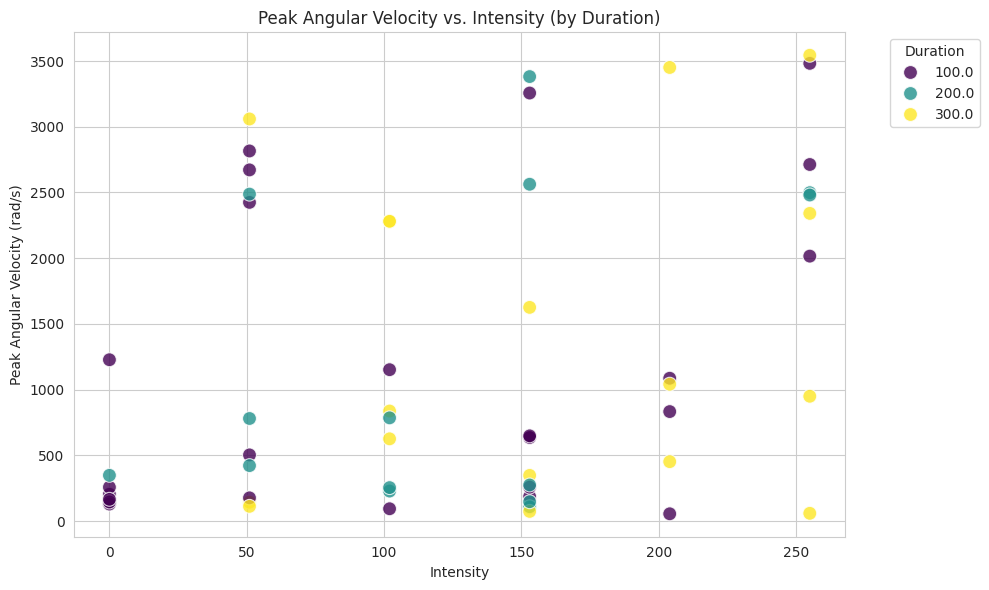

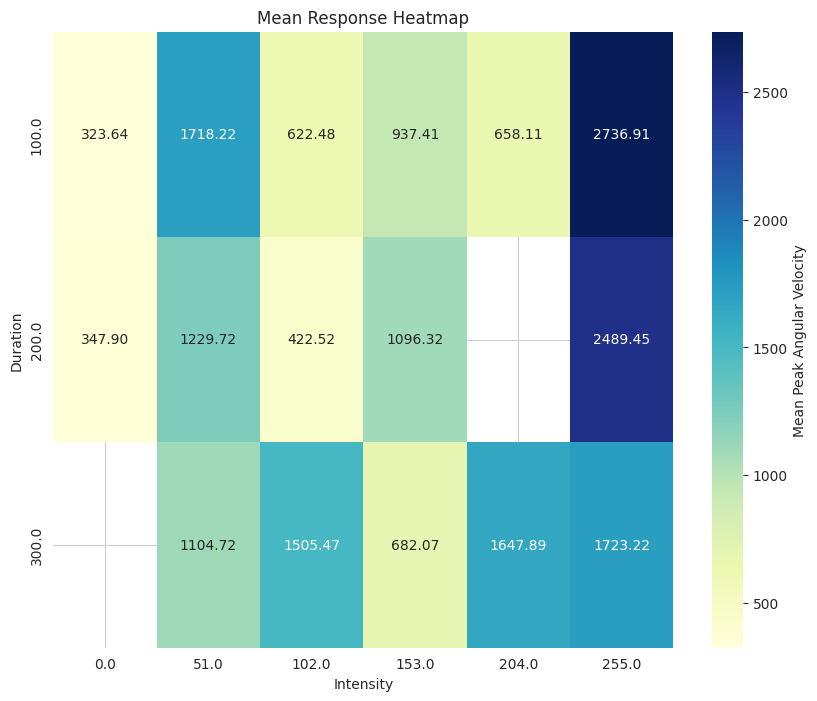

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Convert the results dictionary to a DataFrame
# We only include the scalar columns, skipping the raw 'angular_velocity' traces
df_results = pd.DataFrame({
    'Intensity': results['intensity'],
    'Duration': results['duration'],
    'Response': results['peak_angular_velocity']
})

# Optional: Round values if you have floating point inconsistencies
df_results['Intensity'] = df_results['Intensity'].round(2)
df_results['Duration'] = df_results['Duration'].round(3)

# Set the visual style
sns.set_style("whitegrid")

# --- PLOT 1: Scatter Plot ---
# Shows the response vs intensity, with colors representing duration
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_results, 
    x='Intensity', 
    y='Response', 
    hue='Duration', 
    palette='viridis', 
    s=100,  # Marker size
    alpha=0.8 # Transparency
)
plt.title('Peak Angular Velocity vs. Intensity (by Duration)')
plt.ylabel('Peak Angular Velocity (rad/s)')
plt.xlabel('Intensity')
plt.legend(title='Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- PLOT 2: Heatmap ---
# Shows the AVERAGE response for each Intensity/Duration pair
# This is useful if you have multiple trials per condition
pivot_table = df_results.groupby(['Duration', 'Intensity'])['Response'].mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_table, 
    annot=True,     # Show the values in the cells
    fmt=".2f",      # Format to 2 decimal places
    cmap="YlGnBu",  # Color map
    cbar_kws={'label': 'Mean Peak Angular Velocity'}
)
plt.title('Mean Response Heatmap')
plt.ylabel('Duration')
plt.xlabel('Intensity')
plt.show()